I. Tiền xử lý và chuẩn bị dữ liệu

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

file_path = r'D:\project\visual\data\owid-co2-data.csv'

df = pd.read_csv(file_path)



C:\Users\vunambac\AppData\Local\Temp\ipykernel_7216\775061852.py:8: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [ ]:
print("Kích thước dữ liệu:", df.shape)
print("\nThông tin cột:")
print(df.info())
print("\nMẫu dữ liệu đầu tiên:")
print(df.head())

missing_values = df.isnull().sum()
print("\nGiá trị thiếu theo cột:")
print(missing_values[missing_values > 0])

In [ ]:
print("\nKiểu dữ liệu từng cột:")
print(df.dtypes)

# Tìm các cột dạng object có thể chứa giá trị sai kiểu (ví dụ: số nhưng lưu dạng chuỗi)
for col in df.select_dtypes(include='object').columns:
    print(f"\nCác giá trị khác thường trong cột {col}:")
    print(df[col].value_counts().head(10))


In [ ]:
# Xem tất cả các giá trị khác nhau trong cột 'country'
unique_countries = df['country'].unique()
print("Số lượng quốc gia khác nhau:", len(unique_countries))
print("\nDanh sách các quốc gia:")
print(unique_countries)


In [3]:
duplicate_rows = df[df.duplicated()]
print("\nSố dòng trùng lặp:", duplicate_rows.shape[0])



Số dòng trùng lặp: 0


In [ ]:
print("\nThống kê mô tả các cột số:")
print(df.describe())

# Trực quan hoá nhanh
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()


In [ ]:
cols_to_check = ['co2', 'gdp', 'population']
for col in cols_to_check:
    if col in df.columns:
        print(f"\nGiá trị âm hoặc 0 trong cột {col}:")
        print(df[df[col] <= 0][['country', 'year', col]].head())


In [ ]:
print("\nSố năm dữ liệu theo quốc gia:")
print(df.groupby('country')['year'].nunique().sort_values(ascending=False).head())

# Kiểm tra missing theo quốc gia
missing_by_country = df.groupby('country').apply(lambda x: x.isnull().sum())
print("\nGiá trị thiếu theo quốc gia (top 5):")
print(missing_by_country.head())


In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title("Ma trận tương quan giữa các biến số")
plt.show()


In [11]:
print("\nKhoảng thời gian dữ liệu:")
print("Từ năm:", df['year'].min(), "→ đến năm:", df['year'].max())



Khoảng thời gian dữ liệu:
Từ năm: 1750 → đến năm: 2023


II. Phân tích phát thải toàn cầu

1.Line Chart: Xu hướng phát thải toàn cầu (1960–2023)

In [4]:
import plotly.express as px
# Lọc dữ liệu toàn cầu
world = df[df['country'] == 'World']
world = world[(world['year'] >= 1750) & (world['year'] <= 2023)]

# Vẽ biểu đồ tương tác
fig = px.line(
    world,
    x='year',
    y='co2',
    title='Tổng phát thải CO₂ toàn cầu (1750–2023)',
    labels={'year': 'Năm', 'co2': 'Phát thải CO₂ (triệu tấn)'},
    hover_data={'year': True, 'co2': ':.2f'},  # hiển thị 2 chữ số thập phân
    template='plotly_dark'  # hoặc 'plotly_white' nếu muốn nền sáng
)

# Tùy chỉnh hiển thị
fig.update_traces(line=dict(color='red', width=3))
fig.update_layout(
    hovermode='x unified',
    font=dict(size=14),
    title_x=0.5
)

# Hiển thị biểu đồ
fig.show()

2.Choropleth Map: Phát thải theo quốc gia

In [36]:

# Giữ dữ liệu cấp quốc gia
countries = df[df['iso_code'].apply(lambda x: isinstance(x, str) and len(x) == 3)]
countries = countries[(countries['year'] >= 1950) & (countries['year'] <= 2023)]
countries = countries.dropna(subset=['co2', 'iso_code'])

# Xác định khoảng giá trị toàn bộ (để thang màu không đổi theo năm)
vmin = countries['co2'].min()
vmax = countries['co2'].max()

# Vẽ bản đồ
fig = px.choropleth(
    countries,
    locations='iso_code',
    color='co2',
    hover_name='country',
    animation_frame='year',
    color_continuous_scale='RdYlBu_r',   
    range_color=[vmin, vmax],           
    #title='Phát thải CO₂ theo quốc gia (1950–2023)',
    labels={'co2': 'Phát thải CO₂ (triệu tấn)', 'year': 'Năm'}
)

# Tùy chỉnh thanh màu và bố cục
fig.update_layout(
    title_x=0.5,
    font=dict(size=12),
    hovermode='closest',
    coloraxis_colorbar=dict(
        title='CO₂ (triệu tấn)',
        tickformat='.0f',
        ticks='outside',
        lenmode='fraction',
        len=0.9,
        yanchor='middle',
        y=0.5,
        outlinewidth=1,
        outlinecolor='black'
    )
)
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 100   # mỗi frame 0.25 giây
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 200

# Hiển thị
fig.show()


3.Bar Chart: Top 10 quốc gia phát thải cao nhất

In [37]:
import pandas as pd
import plotly.express as px

# Giữ dữ liệu cấp quốc gia
countries = df[df['iso_code'].apply(lambda x: isinstance(x, str) and len(x) == 3)]
countries = countries[(countries['year'] >= 1950) & (countries['year'] <= 2023)]
countries = countries.dropna(subset=['co2', 'iso_code'])

# Tính tổng phát thải CO₂ của mỗi quốc gia trong giai đoạn 1950–2023
top_emitters = (
    countries.groupby('country', as_index=False)['co2']
    .sum()
    .sort_values(by='co2', ascending=False)
    .head(10)
)

# Vẽ biểu đồ cột
fig = px.bar(
    top_emitters,
    x='country',
    y='co2',
    color='co2',
    color_continuous_scale='RdYlBu_r',  # Đỏ → xanh (phân biệt mạnh)
    labels={'co2': 'Tổng phát thải CO₂ (triệu tấn)', 'country': 'Quốc gia'},
    title='Top 10 quốc gia phát thải CO₂ cao nhất (1950–2023)'
)

# Tùy chỉnh hiển thị
fig.update_layout(
    title_x=0.5,
    xaxis_tickangle=-30,
    font=dict(size=13),
    coloraxis_colorbar=dict(title='CO₂ (triệu tấn)')
)

fig.show()


Sự thay đổi của các nguồn phát thải CO₂ toàn cầu (1750–2023)

In [5]:


# Lọc dữ liệu toàn cầu
world = df[df['country'] == 'World']
world = world[(world['year'] >= 1750) & (world['year'] <= 2023)]

# Chọn các nguồn phát thải chính
sources = ['coal_co2', 'oil_co2', 'gas_co2', 'cement_co2', 'flaring_co2', 'land_use_change_co2']

# Chuyển dữ liệu từ dạng wide → long để vẽ stacked area
world_long = world.melt(
    id_vars=['year'],
    value_vars=sources,
    var_name='Nguồn phát thải',
    value_name='Lượng CO₂ (triệu tấn)'
)

# Đổi tên các nguồn cho dễ đọc
name_map = {
    'coal_co2': 'Than đá',
    'oil_co2': 'Dầu mỏ',
    'gas_co2': 'Khí đốt tự nhiên',
    'cement_co2': 'Xi măng',
    'flaring_co2': 'Đốt khí thừa',
    'land_use_change_co2': 'Thay đổi sử dụng đất'
}
world_long['Nguồn phát thải'] = world_long['Nguồn phát thải'].map(name_map)

# Vẽ biểu đồ stacked area chart tương tác
fig = px.area(
    world_long,
    x='year',
    y='Lượng CO₂ (triệu tấn)',
    color='Nguồn phát thải',
    title='Các nguồn phát thải CO₂ toàn cầu (1750–2023)',
    labels={'year': 'Năm', 'Lượng CO₂ (triệu tấn)': 'Phát thải CO₂ (triệu tấn)'},
    template='plotly_white'
)

# Tùy chỉnh giao diện
fig.update_layout(
    hovermode='x unified',
    title_x=0.5,
    font=dict(size=14),
    legend_title_text='Nguồn phát thải',
    yaxis=dict(title='Phát thải CO₂ (triệu tấn)')
)

# Hiển thị
fig.show()


In [46]:
import plotly.express as px

# Dữ liệu toàn cầu
world = df[df['country'] == 'World']
world = world[(world['year'] >= 1850) & (world['year'] <= 2023)]

# Chuyển sang dạng long
cols = ['temperature_change_from_co2', 'temperature_change_from_ch4',
        'temperature_change_from_n2o', 'temperature_change_from_ghg']
world_long = world.melt(id_vars='year', value_vars=cols,
                        var_name='Nguồn khí', value_name='Mức tăng nhiệt độ (°C)')

# Đổi tên cột cho dễ hiểu
name_map = {
    'temperature_change_from_co2': 'CO₂',
    'temperature_change_from_ch4': 'CH₄',
    'temperature_change_from_n2o': 'N₂O',
    'temperature_change_from_ghg': 'Tổng khí nhà kính'
}
world_long['Nguồn khí'] = world_long['Nguồn khí'].map(name_map)

# Vẽ biểu đồ
fig = px.line(
    world_long, x='year', y='Mức tăng nhiệt độ (°C)', color='Nguồn khí',
    title='Đóng góp của từng khí nhà kính vào sự nóng lên toàn cầu (1850–2023)',
    template='plotly_white'
)
fig.update_layout(title_x=0.5, hovermode='x unified')
fig.show()


In [61]:
top_countries = df.groupby("country")["co2"].max().nlargest(5).index

fig1 = px.line(
    df[df["country"].isin(top_countries)],
    x="year",
    y="co2_per_capita",
    color="country",
    title="Phát thải CO₂ bình quân đầu người (Top 5 quốc gia)",
    labels={
        "year": "Năm",
        "co2_per_capita": "CO₂ trên mỗi người (tấn/người)",
        "country": "Quốc gia"
    }
)
fig1.show()


In [64]:
year_select = 2020  # có thể thay đổi
data_year = df[df["year"] == year_select].copy()

# Tạo cột GDP/người
data_year["gdp_per_capita"] = data_year["gdp"] / data_year["population"]

# Lấy top 10 quốc gia có GDP/người cao nhất
top10_gdp = data_year.nlargest(10, "gdp_per_capita")

# --- Tham số bạn có thể tự chỉnh ---
bubble_size_max = 100   # ⚙️ tăng giá trị này để bong bóng to hơn (ví dụ 60–120)
bubble_size_scale = 1e-6  # ⚙️ giảm/tăng giá trị này để scale lại dân số

# Tạo cột size scale theo tỉ lệ dân số
top10_gdp["size_scaled"] = top10_gdp["population"] * bubble_size_scale

# Vẽ biểu đồ
fig2 = px.scatter(
    top10_gdp,
    x="gdp_per_capita",
    y="co2_per_capita",
    size="size_scaled",
    color="country",
    hover_name="country",
    size_max=bubble_size_max,
    title=f"Top 10 quốc gia có GDP/người cao nhất và phát thải CO₂/người ({year_select})",
    labels={
        "gdp_per_capita": "GDP bình quân đầu người ($)",
        "co2_per_capita": "Phát thải CO₂ bình quân đầu người (tấn)",
        "country": "Quốc gia"
    }
)

fig2.show()


In [70]:
df["gdp_per_capita"] = df["gdp"] / df["population"]

# Lọc từ năm 1900 trở đi
df_filtered = df[df["year"] >= 1950]

# Top 10 quốc gia có GDP/người cao nhất
top_countries = df_filtered.groupby("country")["gdp_per_capita"].max().nlargest(10).index
df_top = df_filtered[df_filtered["country"].isin(top_countries)]

# Biểu đồ xu hướng
fig3 = px.line(
    df_top,
    x="year",
    y="co2_per_capita",
    color="country",
    title="Xu hướng phát thải CO₂ bình quân đầu người (Top 10 quốc gia có GDP/người cao nhất)",
    labels={"year": "Năm", "co2_per_capita": "CO₂/người (tấn)", "country": "Quốc gia"},
)
fig3.show()


In [74]:
df["gdp_per_capita"] = df["gdp"] / df["population"]

# Lọc từ năm 1900 trở đi
df_filtered = df[df["year"] >= 1950]

# Top 10 quốc gia có phát thải CO₂/người cao nhất
top_countries = df_filtered.groupby("country")["co2_per_capita"].max().nlargest(10).index
df_top = df_filtered[df_filtered["country"].isin(top_countries)]

# Biểu đồ xu hướng
fig3 = px.line(
    df_top,
    x="year",
    y="co2_per_capita",
    color="country",
    title="Xu hướng phát thải CO₂ bình quân đầu người (Top 10 quốc gia phát thải cao nhất)",
    labels={
        "year": "Năm",
        "co2_per_capita": "Phát thải CO₂/người (tấn)",
        "country": "Quốc gia"
    }
)
fig3.show()


In [55]:
cols = ["country", "year", "consumption_co2", "trade_co2"]
df_trade = df.dropna(subset=cols)

top_countries_trade = df_trade.groupby("country")["trade_co2"].max().nlargest(10).index
data_trade = df_trade[df_trade["country"].isin(top_countries_trade)]

fig4 = px.bar(
    data_trade,
    x="year",
    y="trade_co2",
    color="country",
    title="Phát thải CO₂ thương mại ròng (Trade CO₂) theo thời gian (Top 10 quốc gia)"
)
fig4.show()


III. Phân tích phát thải Việt Nam

1.Line Chart: Xu hướng phát thải CO₂ tại Việt Nam

In [41]:
import plotly.express as px

# Lọc dữ liệu Việt Nam
vietnam = df[df['country'] == 'Vietnam']
vietnam = vietnam[(vietnam['year'] >= 1750) & (vietnam['year'] <= 2023)]
vietnam = vietnam.dropna(subset=['co2'])

# Vẽ biểu đồ tương tác
fig = px.line(
    vietnam,
    x='year',
    y='co2',
    title='Phát thải CO₂ của Việt Nam (1750–2023)',
    labels={'year': 'Năm', 'co2': 'Phát thải CO₂ (triệu tấn)'},
    hover_data={'year': True, 'co2': ':.2f'},
    template='plotly_white'  # hoặc 'plotly_dark' nếu thích nền tối
)

# Tùy chỉnh hiển thị
fig.update_traces(line=dict(color='royalblue', width=3))
fig.update_layout(
    hovermode='x unified',
    font=dict(size=14),
    title_x=0.5,
    plot_bgcolor='rgba(240,240,240,0.9)',  # nền nhẹ
    margin=dict(l=60, r=60, t=60, b=60)
)

# Hiển thị
fig.show()


2.Stacked Area Chart: Phân tách phát thải theo ngành

In [42]:
import plotly.express as px
import pandas as pd

# Lọc dữ liệu Việt Nam
vn = df[df['country'] == 'Vietnam']
vn = vn[(vn['year'] >= 1950) & (vn['year'] <= 2023)]

# Chọn các ngành chính
vn = vn[['year', 'coal_co2', 'oil_co2', 'gas_co2', 'cement_co2', 'land_use_change_co2']]
vn = vn.dropna(how='any')

# Đổi tên cột để hiển thị đẹp hơn
vn = vn.rename(columns={
    'coal_co2': 'Than',
    'oil_co2': 'Dầu',
    'gas_co2': 'Khí đốt',
    'cement_co2': 'Xi măng',
    'land_use_change_co2': 'Thay đổi sử dụng đất'
})

# Chuyển dữ liệu sang dạng "long" để plotly hiểu
vn_melt = vn.melt(id_vars='year', var_name='Ngành', value_name='Phát thải (triệu tấn)')

# Vẽ stacked area chart
fig = px.area(
    vn_melt,
    x='year',
    y='Phát thải (triệu tấn)',
    color='Ngành',
    title='Cơ cấu phát thải CO₂ theo ngành tại Việt Nam (1950–2023)',
    labels={'year': 'Năm'},
    template='plotly_white'
)

# Tùy chỉnh hiển thị
fig.update_layout(
    hovermode='x unified',
    font=dict(size=14),
    title_x=0.5,
    legend_title_text='Nguồn phát thải',
    yaxis_title='Phát thải CO₂ (triệu tấn)',
    xaxis_title='Năm',
    plot_bgcolor='rgba(240,240,240,0.9)',
    margin=dict(l=60, r=60, t=60, b=60)
)

# Hiển thị
fig.show()


tốc độ tăng phát thải thế giới nói chung 

C:\Users\vunambac\AppData\Local\Temp\ipykernel_10924\1202182952.py:8: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Top 10 quốc gia riêng lẻ có tốc độ tăng CO2 trung bình cao nhất (2013-nay):
          country  co2_growth_prct
114          Laos        23.649364
143    Mozambique        13.918364
36       Cambodia        12.982818
211    Tajikistan        11.843545
147         Nepal        11.717364
47        Comoros        11.042818
144       Myanmar        10.189000
129          Mali         9.950636
232       Vietnam         8.607636
34   Burkina Faso         8.561182


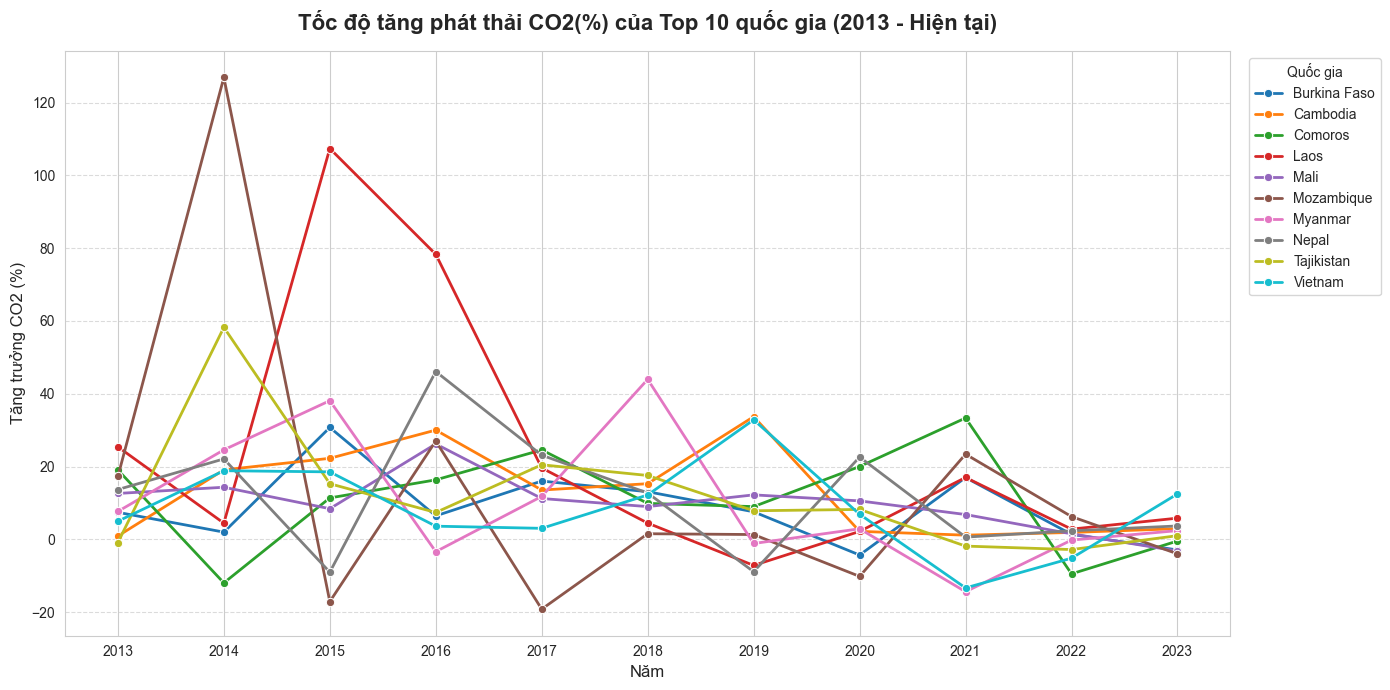

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Đọc dữ liệu
file_path = r'D:\project\visual\data\owid-co2-data.csv'
df = pd.read_csv(file_path)

# Chọn cột cần thiết
df_growth = df[['country', 'year', 'co2_growth_prct']].copy()

# Định nghĩa danh sách các hạng mục tổng hợp cần loại trừ
countries_to_exclude = [
    'World', 'Asia', 'Europe', 'North America', 'Africa', 'South America', 
    'Oceania', 'International transport', 'Upper-middle-income countries', 
    'High-income countries', 'Lower-middle-income countries', 'Low-income countries',
    'European Union (28)', 'European Union (27)', 'Asia (excl. China and India)',
    'North America (excl. USA)', 'Europe (excl. EU-28)', 'Europe (excl. EU-27)',
    'Middle East (including Turkey)', 'Central and South America', 'Non-OECD', 'OECD',
    # Bổ sung các khu vực khác có thể xuất hiện
    'Africa (excl. South Africa)', 'G20', 'BRICS'
]

# Lọc dữ liệu từ năm gần đây (2013-nay)
recent_years = df_growth[df_growth['year'] >= 2013].copy()

# --- BƯỚC SỬA ĐỔI QUAN TRỌNG: Lọc Bỏ Hạng Mục Tổng Hợp ---
recent_years_countries = recent_years[~recent_years['country'].isin(countries_to_exclude)].copy()


# Tính tốc độ tăng trung bình cho mỗi quốc gia
# Chỉ tính trung bình cho các quốc gia riêng lẻ
avg_growth = recent_years_countries.groupby('country')['co2_growth_prct'].mean().reset_index()

# Lấy 10 quốc gia có tốc độ tăng trung bình cao nhất
top10 = avg_growth.sort_values(by='co2_growth_prct', ascending=False).head(10)

print("Top 10 quốc gia riêng lẻ có tốc độ tăng CO2 trung bình cao nhất (2013-nay):")
print(top10)

# Lấy dữ liệu đầy đủ của 10 quốc gia này (sau khi đã lọc bỏ hạng mục tổng hợp)
df_top10 = recent_years_countries[recent_years_countries['country'].isin(top10['country'])]

# --- Vẽ biểu đồ tốc độ tăng theo năm ---
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid") # Thêm style để biểu đồ rõ ràng hơn

sns.lineplot(
    data=df_top10, 
    x='year', 
    y='co2_growth_prct', 
    hue='country', 
    marker='o',
    linewidth=2,
    markersize=6
)

plt.title('Tốc độ tăng phát thải CO2(%) của Top 10 quốc gia (2013 - Hiện tại)', 
          fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Tăng trưởng CO2 (%)', fontsize=12)
plt.xlabel('Năm', fontsize=12)

# Điều chỉnh trục X để hiển thị các năm là số nguyên
plt.xticks(df_top10['year'].unique().astype(int))

# Đặt legend ra ngoài để không che dữ liệu
plt.legend(title='Quốc gia', bbox_to_anchor=(1.01, 1), loc='upper left', frameon=True)
plt.grid(axis='y', linestyle='--', alpha=0.7) # Chỉ để gridlines ở trục y

plt.tight_layout()
plt.show()

Cái này là đông nam á nha 

chạy code sẽ thấy một cái bảng ở bên trên biểu đồ cho thấy vn top 3. Trong báo cáo ae ghi cả là top 1 là top 2 là top 3 là vơí cái này là tốc độ tăng trường theo đơn vị phần trăm 

Top 10 quốc gia Đông Nam Á có tốc độ tăng CO2 trung bình cao nhất (2013-nay):
       country  co2_growth_prct
3         Laos        23.649364
1     Cambodia        12.982818
5      Myanmar        10.189000
9      Vietnam         8.607636
6  Philippines         5.368818
2    Indonesia         3.491455
4     Malaysia         2.931455
0       Brunei         2.855273
7    Singapore         0.661818
8     Thailand         0.096545


C:\Users\vunambac\AppData\Local\Temp\ipykernel_10924\3933933780.py:7: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


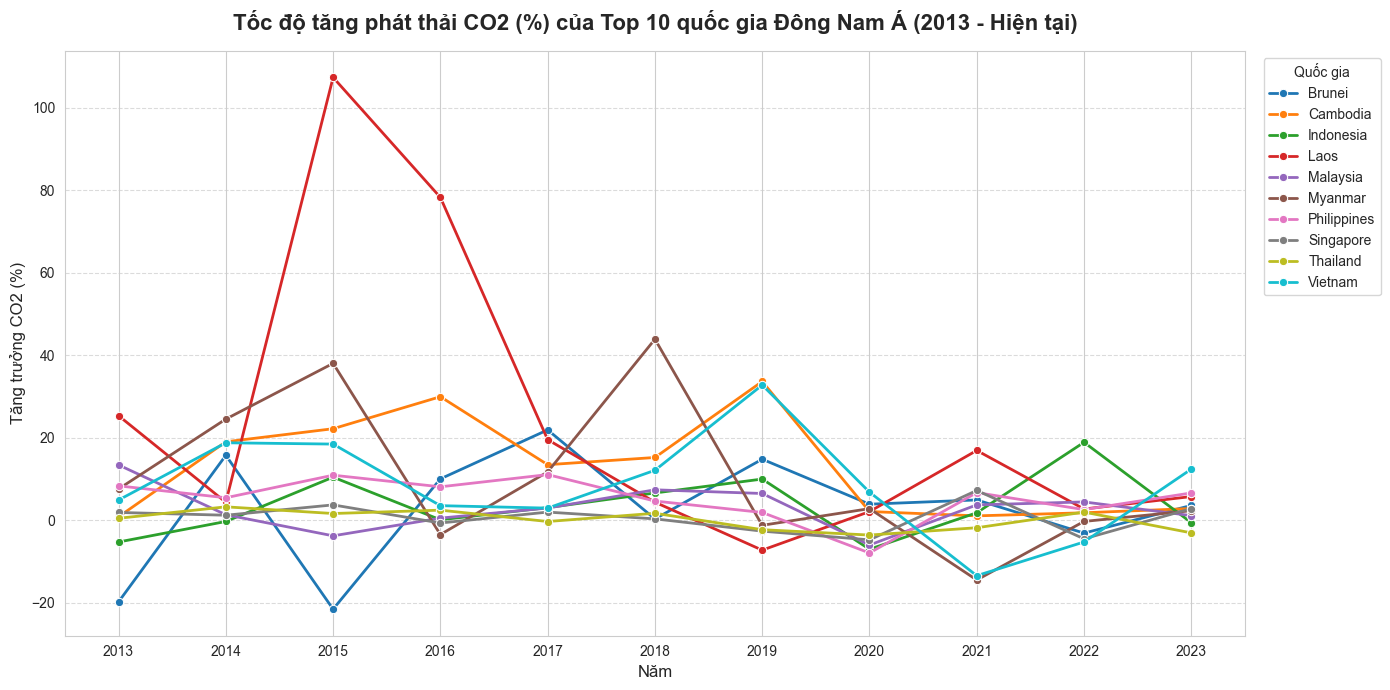

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu
file_path = r'D:\project\visual\data\owid-co2-data.csv'
df = pd.read_csv(file_path)

# Chọn cột cần thiết
df_growth = df[['country', 'year', 'co2_growth_prct']].copy()

# Danh sách các nước Đông Nam Á
asean_countries = [
    'Brunei', 'Cambodia', 'Indonesia', 'Laos', 'Malaysia', 'Myanmar', 
    'Philippines', 'Singapore', 'Thailand', 'Timor', 'Vietnam'
]

# Lọc dữ liệu từ năm 2013 trở đi
recent_years = df_growth[df_growth['year'] >= 2013].copy()

# Chỉ giữ các quốc gia Đông Nam Á
asean_data = recent_years[recent_years['country'].isin(asean_countries)].copy()

# Tính tốc độ tăng trung bình cho mỗi quốc gia Đông Nam Á
avg_growth_asean = asean_data.groupby('country')['co2_growth_prct'].mean().reset_index()

# Lấy 10 quốc gia Đông Nam Á có tốc độ tăng trung bình cao nhất
top10_asean = avg_growth_asean.sort_values(by='co2_growth_prct', ascending=False).head(10)

print("Top 10 quốc gia Đông Nam Á có tốc độ tăng CO2 trung bình cao nhất (2013-nay):")
print(top10_asean)

# Lấy dữ liệu đầy đủ của 10 quốc gia này
df_top10_asean = asean_data[asean_data['country'].isin(top10_asean['country'])]

# Vẽ biểu đồ tốc độ tăng theo năm
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

sns.lineplot(
    data=df_top10_asean,
    x='year',
    y='co2_growth_prct',
    hue='country',
    marker='o',
    linewidth=2,
    markersize=6
)

plt.title('Tốc độ tăng phát thải CO2 (%) của Top 10 quốc gia Đông Nam Á (2013 - Hiện tại)',
          fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Tăng trưởng CO2 (%)', fontsize=12)
plt.xlabel('Năm', fontsize=12)
plt.xticks(df_top10_asean['year'].unique().astype(int))
plt.legend(title='Quốc gia', bbox_to_anchor=(1.01, 1), loc='upper left', frameon=True)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
